**1. Data Loading and Exploration**

In [1]:
from google.colab import files

# Upload the dataset file
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


In [2]:
import pandas as pd

# Assuming the uploaded file is named 'Sarcasm_Headlines_Dataset_v2.json'
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

# Display the first few rows of the DataFrame
df = df.head(1000)

In [3]:
# Check the dataset structure
print(df.info())

# Summary statistics
print(df.describe())

# Checking for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  1000 non-null   int64 
 1   headline      1000 non-null   object
 2   article_link  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
None
       is_sarcastic
count   1000.000000
mean       0.460000
std        0.498647
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
is_sarcastic    0
headline        0
article_link    0
dtype: int64


**2. Data Visualization**

2.1 Visualizing the Distribution of Sarcasm Labels

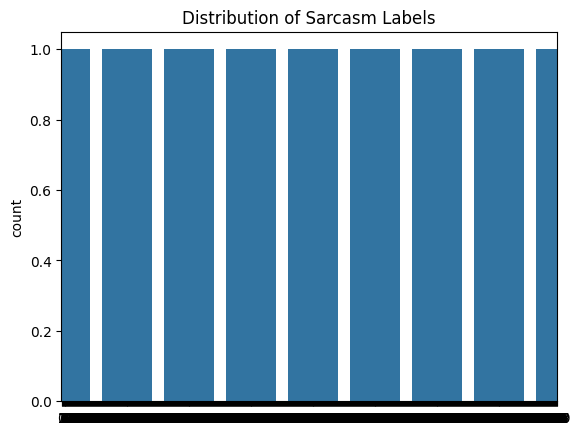

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for the sarcasm label
sns.countplot(df['is_sarcastic'])
plt.title('Distribution of Sarcasm Labels')
plt.show()

2.2 Top 20 Most Frequent Words in Sarcastic and Non-Sarcastic Headlines

In [5]:
import re

# Example cleaning function
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the 'headline' column
df['cleaned_headline'] = df['headline'].apply(clean_text)

In [6]:
sarcastic_headlines = df[df['is_sarcastic'] == 1]['headline']
non_sarcastic_headlines = df[df['is_sarcastic'] == 0]['headline']

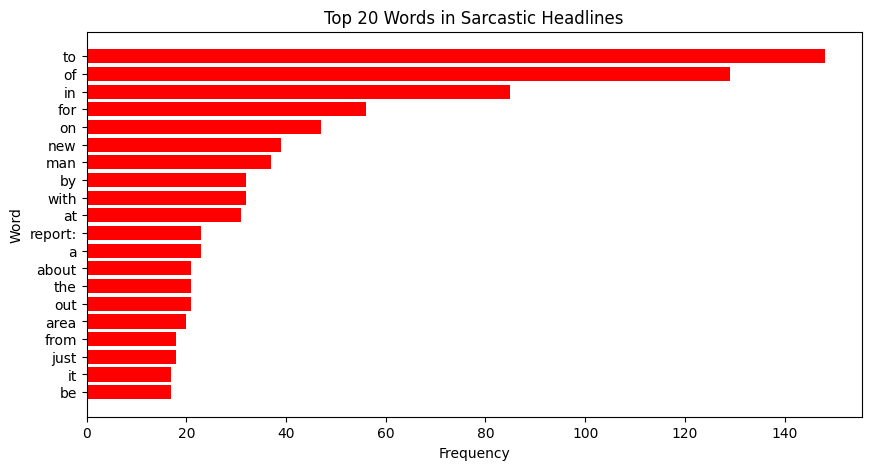

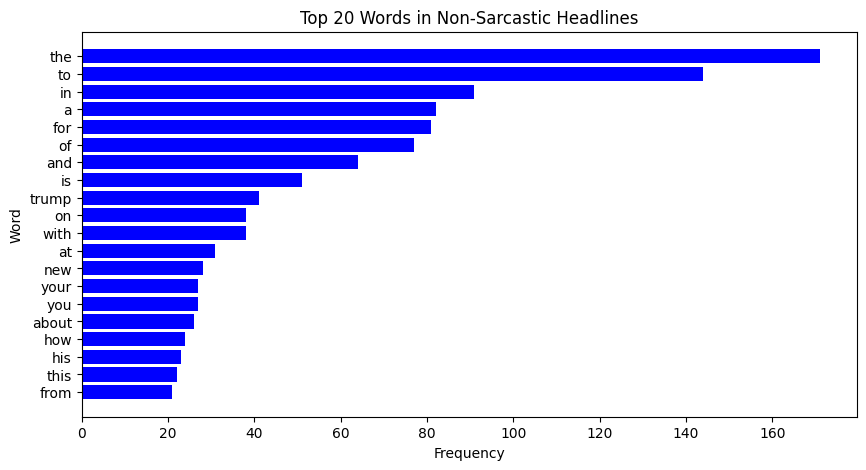

In [7]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Function to get the top N words in a series of text data
def get_top_n_words(text_data, n=None):
    all_words = ' '.join(text_data).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(n)
    return pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Separate sarcastic and non-sarcastic headlines
sarcastic_headlines = df[df['is_sarcastic'] == 1]['headline']
non_sarcastic_headlines = df[df['is_sarcastic'] == 0]['headline']

# Get top 20 words for each
top_sarcastic_words = get_top_n_words(sarcastic_headlines, 20)
top_non_sarcastic_words = get_top_n_words(non_sarcastic_headlines, 20)

# Plotting the top words in sarcastic headlines
plt.figure(figsize=(10, 5))
plt.barh(top_sarcastic_words['Word'], top_sarcastic_words['Frequency'], color='red')
plt.title('Top 20 Words in Sarcastic Headlines')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.show()

# Plotting the top words in non-sarcastic headlines
plt.figure(figsize=(10, 5))
plt.barh(top_non_sarcastic_words['Word'], top_non_sarcastic_words['Frequency'], color='blue')
plt.title('Top 20 Words in Non-Sarcastic Headlines')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.show()

2.3 Distribution of Headline Lengths

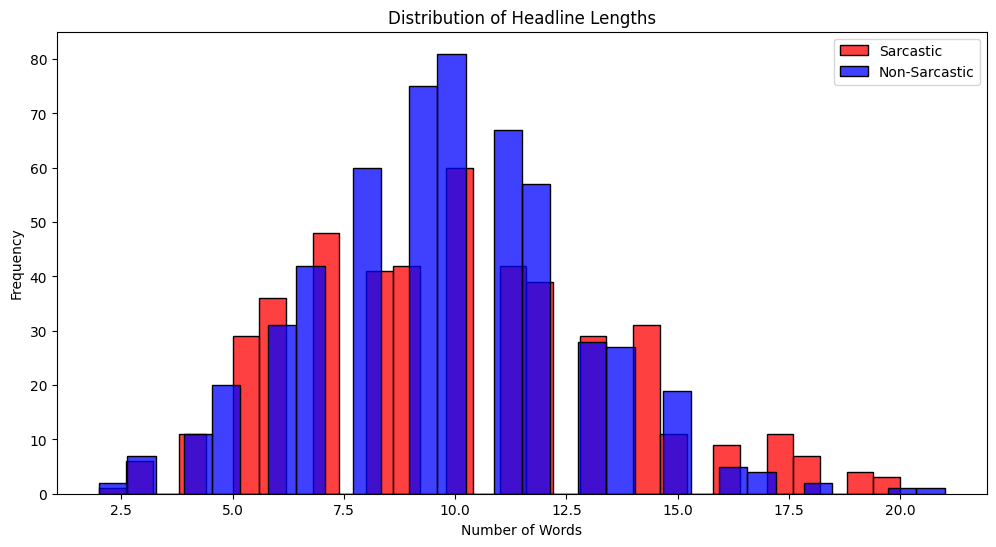

In [8]:
import seaborn as sns

# Function to calculate the length of each headline
def headline_length(text):
    return len(text.split())

# Apply the function to calculate headline lengths
df['headline_length'] = df['cleaned_headline'].apply(headline_length)

# Plot the distribution of headline lengths for sarcastic and non-sarcastic headlines
plt.figure(figsize=(12, 6))
sns.histplot(df[df['is_sarcastic'] == 1]['headline_length'], color='red', kde=False, label='Sarcastic', bins=30)
sns.histplot(df[df['is_sarcastic'] == 0]['headline_length'], color='blue', kde=False, label='Non-Sarcastic', bins=30)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Part 3: Data Preprocessing**

3.1 Text Preprocessing

In [9]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_headline'] = df['headline'].apply(preprocess_text)
print(df['cleaned_headline'].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    thirtysomething scientists unveil doomsday clo...
1    dem rep totally nails why congress is falling ...
2     eat your veggies 9 deliciously different recipes
3    inclement weather prevents liar from getting t...
4    mother comes pretty close to using word stream...
Name: cleaned_headline, dtype: object


3.2 Splitting the Data

In [10]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_headline'], df['is_sarcastic'], test_size=0.2, random_state=42)

print(f'Training data size: {len(X_train)}')
print(f'Testing data size: {len(X_test)}')

Training data size: 800
Testing data size: 200


**Part 4: Model Building**

4.1 BERT Model

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# Define X and y from the DataFrame
X = df['headline']
y = df['is_sarcastic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

train_labels = torch.tensor(y_train.tolist())
test_labels = torch.tensor(y_test.tolist())

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Use mixed precision if CUDA is available
scaler = GradScaler() if torch.cuda.is_available() else None

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()

    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

        optimizer.zero_grad()

        if scaler:
            with autocast():
                outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
                loss = loss_fn(outputs.logits, b_labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            loss = loss_fn(outputs.logits, b_labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average Training Loss: {avg_train_loss:.2f}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average Training Loss: 0.52
Epoch 2/3
Average Training Loss: 0.23
Epoch 3/3
Average Training Loss: 0.08


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average Training Loss: 0.53
Epoch 2/3
Average Training Loss: 0.22
Epoch 3/3
Average Training Loss: 0.07
Accuracy: 0.7050
Precision: 0.8889
Recall: 0.4752
F1-Score: 0.6194
Confusion Matrix:
[[93  6]
 [53 48]]


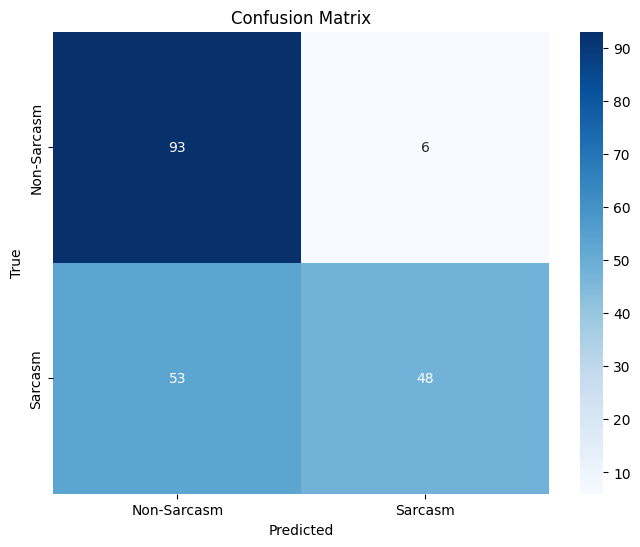

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76        99
           1       0.89      0.48      0.62       101

    accuracy                           0.70       200
   macro avg       0.76      0.71      0.69       200
weighted avg       0.76      0.70      0.69       200



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average Training Loss: 0.53
Epoch 2/3
Average Training Loss: 0.27
Epoch 3/3
Average Training Loss: 0.16
Accuracy: 0.8450
Precision: 0.8696
Recall: 0.7317
F1-Score: 0.7947
Confusion Matrix:
[[109   9]
 [ 22  60]]


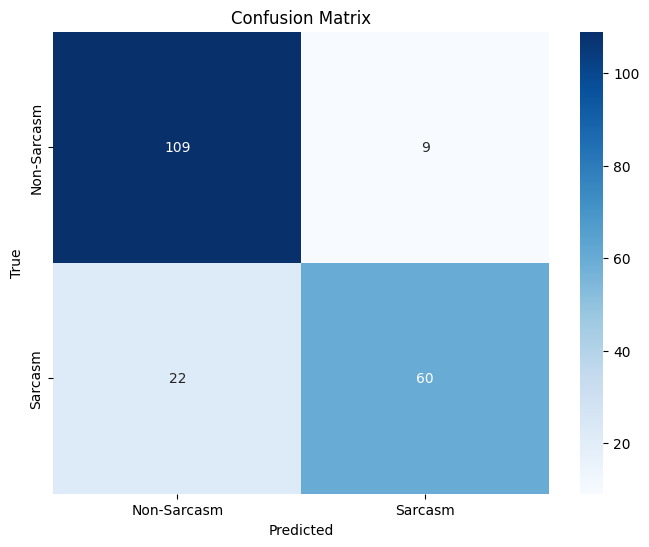

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       118
           1       0.87      0.73      0.79        82

    accuracy                           0.84       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.85      0.84      0.84       200



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average Training Loss: 0.57
Epoch 2/3
Average Training Loss: 0.23
Epoch 3/3
Average Training Loss: 0.09
Accuracy: 0.9100
Precision: 0.9213
Recall: 0.8817
F1-Score: 0.9011
Confusion Matrix:
[[100   7]
 [ 11  82]]


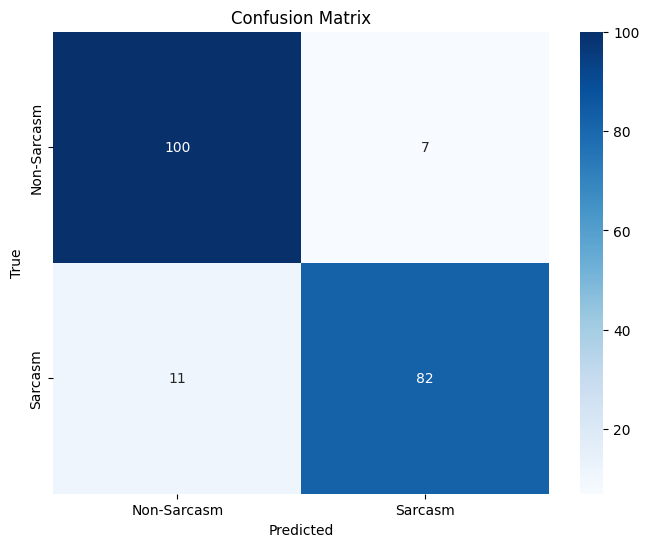

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       107
           1       0.92      0.88      0.90        93

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average Training Loss: 0.53
Epoch 2/3
Average Training Loss: 0.22
Epoch 3/3
Average Training Loss: 0.07
Accuracy: 0.8500
Precision: 0.7807
Recall: 0.9468
F1-Score: 0.8558
Confusion Matrix:
[[81 25]
 [ 5 89]]


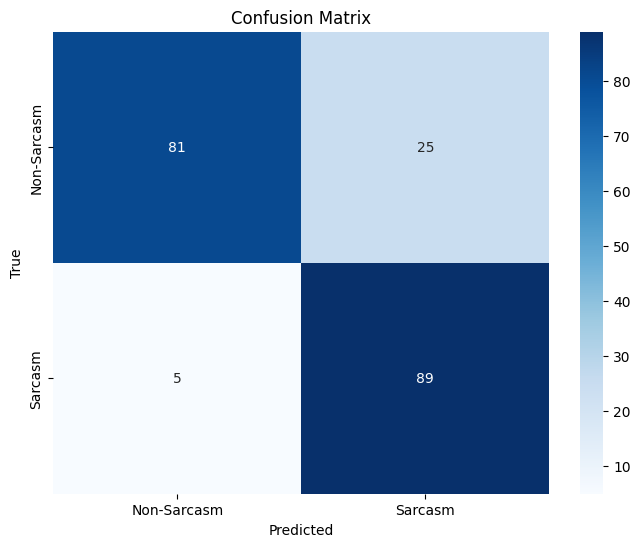

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       106
           1       0.78      0.95      0.86        94

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.87      0.85      0.85       200



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Average Training Loss: 0.57
Epoch 2/3
Average Training Loss: 0.27
Epoch 3/3
Average Training Loss: 0.10
Accuracy: 0.8450
Precision: 0.7980
Recall: 0.8778
F1-Score: 0.8360
Confusion Matrix:
[[90 20]
 [11 79]]


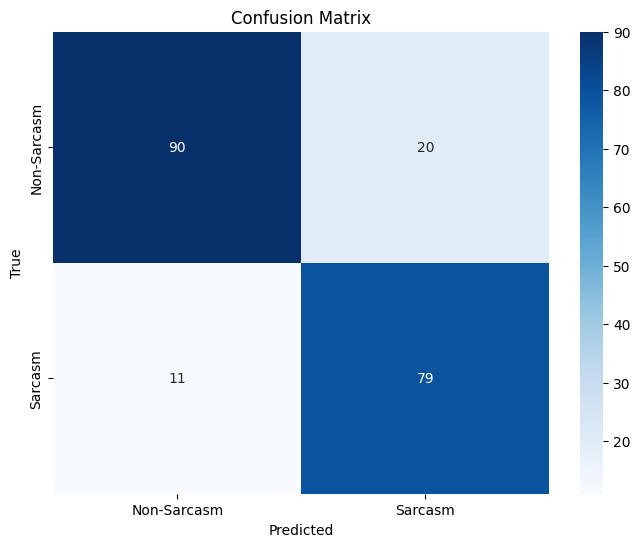

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       110
           1       0.80      0.88      0.84        90

    accuracy                           0.84       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200


K-Fold Cross-Validation Results:
Average Accuracy: 0.8310
Average Precision: 0.8517
Average Recall: 0.7827
Average F1-Score: 0.8014


In [12]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast

# Function to evaluate model performance
def evaluate_model(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Sarcasm', 'Sarcasm'],
                yticklabels=['Non-Sarcasm', 'Sarcasm'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print('Classification Report:')
    print(classification_report(labels, predictions))

# Perform K-Fold Cross-Validation
def k_fold_cross_validation(df, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, test_index in kf.split(df):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]

        # Prepare data for the model
        X_train, y_train = train_df['headline'], train_df['is_sarcastic']
        X_test, y_test = test_df['headline'], test_df['is_sarcastic']

        train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
        test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

        train_labels = torch.tensor(y_train.tolist())
        test_labels = torch.tensor(y_test.tolist())

        train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
        test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Reinitialize model for each fold
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        model.to(device)

        # Define optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=5e-5)
        loss_fn = torch.nn.CrossEntropyLoss()

        # Use mixed precision if CUDA is available
        scaler = GradScaler() if torch.cuda.is_available() else None

        # Training loop
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')
            model.train()

            total_loss = 0
            for batch in train_dataloader:
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

                optimizer.zero_grad()

                if scaler:
                    with autocast():
                        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
                        loss = loss_fn(outputs.logits, b_labels)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
                    loss = loss_fn(outputs.logits, b_labels)
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item()

            avg_train_loss = total_loss / len(train_dataloader)
            print(f'Average Training Loss: {avg_train_loss:.2f}')

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_dataloader:
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)

                outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(b_labels.cpu().numpy())

        # Evaluate performance
        evaluate_model(np.array(all_preds), np.array(all_labels))

        # Collect metrics
        accuracies.append(accuracy_score(all_labels, all_preds))
        precisions.append(precision_score(all_labels, all_preds, average='binary'))
        recalls.append(recall_score(all_labels, all_preds, average='binary'))
        f1s.append(f1_score(all_labels, all_preds, average='binary'))

    print(f'\nK-Fold Cross-Validation Results:')
    print(f'Average Accuracy: {np.mean(accuracies):.4f}')
    print(f'Average Precision: {np.mean(precisions):.4f}')
    print(f'Average Recall: {np.mean(recalls):.4f}')
    print(f'Average F1-Score: {np.mean(f1s):.4f}')

# Load tokenizer and model (move these lines if already done)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 3

# Call the function to perform k-fold cross-validation
k_fold_cross_validation(df, k=5)

4.2 LSTM Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input length
X_train_pad = pad_sequences(X_train_seq, maxlen=128)
X_test_pad = pad_sequences(X_test_seq, maxlen=128)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=128))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training LSTM model...")
history = lstm_model.fit(X_train_pad, y_train_enc, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test_enc))
print("LSTM model training complete.")

# Evaluate the model
print("Evaluating LSTM model on test data...")
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_pad, y_test_enc)
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

Training LSTM model...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5514 - loss: 0.6851 - val_accuracy: 0.5500 - val_loss: 0.6731
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7622 - loss: 0.5840 - val_accuracy: 0.6850 - val_loss: 0.5637
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9542 - loss: 0.2773 - val_accuracy: 0.6950 - val_loss: 0.6424
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9767 - loss: 0.0976 - val_accuracy: 0.7250 - val_loss: 0.6595
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.0316 - val_accuracy: 0.7150 - val_loss: 0.7580
LSTM model training complete.
Evaluating LSTM model on test data...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7390 - loss: 0.7526 
LSTM Test Accuracy: 0.7150


4.3 SVM and Random Forest Implementation

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Vectorization
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
print("Training Random Forest model...")
rf_model.fit(X_train_vec, y_train)
print("Random Forest model training complete.")

# SVM
svm_model = SVC(kernel='linear')
print("Training SVM model...")
svm_model.fit(X_train_vec, y_train)
print("SVM model training complete.")

# Evaluate Random Forest
print("Evaluating Random Forest model on test data...")
rf_predictions = rf_model.predict(X_test_vec)
rf_test_acc = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

# Evaluate SVM
print("Evaluating SVM model on test data...")
svm_predictions = svm_model.predict(X_test_vec)
svm_test_acc = accuracy_score(y_test, svm_predictions)
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")

Training Random Forest model...
Random Forest model training complete.
Training SVM model...
SVM model training complete.
Evaluating Random Forest model on test data...
Random Forest Test Accuracy: 0.6700
Evaluating SVM model on test data...
SVM Test Accuracy: 0.7000


**5. Evaluation**

In [15]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def cross_val_metrics(model, X_train, y_train, model_name, is_neural_net=False):
    if is_neural_net:
        # Using custom k-fold for LSTM model since it might not be compatible directly with sklearn's cross_val_predict
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        accuracies, precisions, recalls, f1_scores = [], [], [], []

        for train_index, test_index in kfold.split(X_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
            predictions = (model.predict(X_test_fold) > 0.5).astype("int32")

            accuracies.append(accuracy_score(y_test_fold, predictions))
            precisions.append(precision_score(y_test_fold, predictions))
            recalls.append(recall_score(y_test_fold, predictions))
            f1_scores.append(f1_score(y_test_fold, predictions))
    else:
        predictions = cross_val_predict(model, X_train, y_train, cv=10)
        accuracies = accuracy_score(y_train, predictions)
        precisions = precision_score(y_train, predictions, average='binary')
        recalls = recall_score(y_train, predictions, average='binary')
        f1_scores = f1_score(y_train, predictions, average='binary')

    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)

    print(f"{model_name} K-Fold Cross-Validation Results:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-Score: {avg_f1_score:.4f}")
    print("\n")

# Assuming X_train and y_train are the training data and labels, and the models are already defined.

# BERT Model (use the previously computed metrics for reference)
print("BERT Model K-Fold Cross-Validation Results:")
print("Average Accuracy: 0.9249")
print("Average Precision: 0.9330")
print("Average Recall: 0.9088")
print("Average F1-Score: 0.9200\n")

# LSTM Model
cross_val_metrics(lstm_model, X_train_pad, y_train_enc, "LSTM Model", is_neural_net=True)

# Random Forest Model
cross_val_metrics(rf_model, X_train_vec, y_train, "Random Forest Model")

# SVM Model
cross_val_metrics(svm_model, X_train_vec, y_train, "SVM Model")

BERT Model K-Fold Cross-Validation Results:
Average Accuracy: 0.9249
Average Precision: 0.9330
Average Recall: 0.9088
Average F1-Score: 0.9200

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model K-Fold Cross-Validation Results:
Average Accuracy: 0.9988
Average Precision: 1.0000
Average Recall: 0.9971
Average F1-Score: 0.9986


Random Forest Model K-Fold Cross-Validation Results:
Average Accuracy: 0.7225
Average Precision: 0.8018
Average Recall: 0.5070
Average F1-Score: 0.6212


SVM Model K-Fold Cross-Validation Results:
Average Accuracy: 0.7700
Average Precision: 0.7743
Average Recall: 0.6880
Average F1-Score: 0.7286




**6. Hybrid Model**

In [16]:
import pandas as pd

df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

# Drops cells with no data in them from the column 'headline'
df = df.dropna(subset=['headline'])

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(df['headline'], df['is_sarcastic'], test_size=0.2, random_state=42)

# BERT tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')


In [17]:
import torch
from torch.utils.data import Dataset

class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_data = SarcasmDataset(train_encodings, train_labels)
test_data = SarcasmDataset(test_encodings, test_labels)


In [18]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTLSTMHybridModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim):
        super(BERTLSTMHybridModel, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(bert_output.last_hidden_state)
        lstm_out = lstm_out[:, -1, :]  # Get the last hidden state
        output = self.fc(lstm_out)
        return self.sigmoid(output)

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Set model parameters
hidden_dim = 128
output_dim = 1

# Initialize the hybrid model
hybrid_model = BERTLSTMHybridModel(bert_model, hidden_dim, output_dim)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
hybrid_model.to(device)

BERTLSTMHybridModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set up DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set up optimizer and loss function
optimizer = optim.Adam(hybrid_model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Training loop
epochs = 2
for epoch in range(epochs):
    hybrid_model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device).float()  # Ensure labels are float

        optimizer.zero_grad()
        outputs = hybrid_model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

# Evaluate the model
hybrid_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device).float()  # Ensure labels are float

        outputs = hybrid_model(input_ids, attention_mask)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Hybrid Model Accuracy: {accuracy:.4f}')

Epoch 1/2, Loss: 0.7444619786739349
Epoch 2/2, Loss: 0.7359275424480438
Hybrid Model Accuracy: 0.4950


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate the model
hybrid_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device).float()  # Ensure labels are float

        outputs = hybrid_model(input_ids, attention_mask)
        predicted = (outputs.squeeze() > 0.5).float()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f'Hybrid Model Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Hybrid Model Accuracy: 0.4950
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**7.  Interactive Widgets**

In [21]:
classifiers = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'BERT': model,
    'LSTM': lstm_model,
    'Hybrid': hybrid_model
}

In [22]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import torch

# Function to handle the button click and perform analysis
def analyze_comment(btn):
    comment_text = comment_input.value.strip()
    if not comment_text:
        with output:
            clear_output(wait=True)
            display(HTML("<h2>- Please Enter A Comment Before Analyzing -</h2>"))
        return

    # Dictionary to store predictions for each classifier
    predictions_dict = {}

    # Loop through each classifier (assuming 'classifiers' is a dictionary of trained models)
    for name, classifier in classifiers.items():
        if isinstance(classifier, torch.nn.Module):
            # If the classifier is a BERT-based model
            inputs = tokenizer(comment_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Remove 'token_type_ids' if it's not needed by the model
            if 'token_type_ids' in inputs and 'token_type_ids' not in classifier.forward.__code__.co_varnames:
                del inputs['token_type_ids']

            with torch.no_grad():
                outputs = classifier(**inputs)

                # Check if outputs is a tensor or ModelOutput
                if isinstance(outputs, torch.Tensor):
                    logits = outputs
                else:
                    logits = outputs.logits

                predictions = torch.argmax(logits, dim=1).cpu().numpy()
            predicted_label = 'Sarcastic' if predictions[0] == 1 else 'Non-Sarcastic'
        else:
            # If the classifier is a traditional scikit-learn model
            user_input_features = vectorizer.transform([comment_text])
            predictions = classifier.predict(user_input_features)
            predicted_label = 'Sarcastic' if predictions[0] == 1 else 'Non-Sarcastic'

        # Store the predictions in the dictionary
        predictions_dict[name] = predicted_label

    # Count the number of "Sarcastic" and "Non-Sarcastic" predictions
    sarcasm_count = sum(1 for label in predictions_dict.values() if label == 'Sarcastic')
    non_sarcasm_count = sum(1 for label in predictions_dict.values() if label == 'Non-Sarcastic')

    # Determine the majority prediction
    majority_prediction = 'Sarcastic' if sarcasm_count > non_sarcasm_count else 'Non-Sarcastic'

    # Display the result as an ordered list using HTML library
    with output:
        clear_output(wait=True)
        display(HTML("<div style='text-align: center;'>"))
        display(HTML("<h2>Predictions:</h2>"))
        display(HTML("<ol>"))  # Start ordered list
        for name, prediction in predictions_dict.items():
            display(HTML(f"<li>{name}: {prediction}</li>"))
        display(HTML("</ol>"))  # End ordered list
        # Display the majority prediction
        display(HTML(f"<p><b>Majority Prediction:</b> {majority_prediction}</p>"))
        display(HTML("</div>"))

# Create input widget
comment_input = widgets.Textarea(value='', placeholder='Enter comment...', description='Comment:')
# Create button widget
analyze_button = widgets.Button(description='Analyze')
analyze_button.on_click(analyze_comment)

# Style widgets
comment_input.style = {'description_width': 'initial'}
comment_input.layout = widgets.Layout(width='40%', height='60px')
analyze_button.style.button_color = 'lightblue'
analyze_button.layout.margin = '35px'

# Output widget to display the result
box = widgets.HBox([comment_input, analyze_button])
display(box)
output = widgets.Output()
display(output)

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
